In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np

import librosa as lr

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf

from glob import glob

import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split

In [0]:
def load_data_spectrum(path, m=26):
  '''
  Load data from file
  Extract filter banks
  return: X_train, y_train, X_test, y_test
  '''
  files = glob(path)
  speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
  X, y = np.zeros((2000, 128, m)), np.zeros(2000)

  for idx, file_path in enumerate(files):
    ## load signal
    signal, rate = lr.load(file_path)

    ## extract fbanks
    fbank = lr.feature.melspectrogram(y=signal, sr=rate)

    ## rescale fbanks
    fbank = cv2.resize(fbank, (m, 128), interpolation=cv2.INTER_AREA)

    ## get label
    file_name = file_path.split('/')[-1] ## get the file name
    speaker_name = file_name.split('_')[1] ## get the speaker name
    label = speakers.index(speaker_name) ## get the label 

    if idx % 100 == 0:
      print("Filter Banks data nb {} extracted".format(idx))
    ## update X and y
    X[idx] = fbank
    y[idx] = label
    
  ## split in training and testing set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  return X_train, y_train, X_test, y_test

In [39]:
path = '/content/drive/My Drive/free-spoken-digit-dataset/recordings/*.wav'
X_train, y_train, X_test, y_test = load_data_spectrum(path)

Filter Banks data nb 0 extracted
Filter Banks data nb 100 extracted
Filter Banks data nb 200 extracted
Filter Banks data nb 300 extracted
Filter Banks data nb 400 extracted
Filter Banks data nb 500 extracted
Filter Banks data nb 600 extracted
Filter Banks data nb 700 extracted
Filter Banks data nb 800 extracted
Filter Banks data nb 900 extracted
Filter Banks data nb 1000 extracted
Filter Banks data nb 1100 extracted
Filter Banks data nb 1200 extracted
Filter Banks data nb 1300 extracted
Filter Banks data nb 1400 extracted
Filter Banks data nb 1500 extracted
Filter Banks data nb 1600 extracted
Filter Banks data nb 1700 extracted
Filter Banks data nb 1800 extracted
Filter Banks data nb 1900 extracted


In [0]:
nb_data_tr, dim, time_step = X_train.shape
nb_data_te, _, _ = X_test.shape

In [41]:
print(X_train.shape)
print(X_test.shape)

(1600, 128, 26)
(400, 128, 26)


In [0]:
X_train = np.reshape(X_train, (nb_data_tr, time_step, dim))
X_test = np.reshape(X_test, (nb_data_te, time_step, dim))

In [47]:
print(X_train.shape)
print(X_test.shape)

(1600, 26, 128)
(400, 26, 128)


In [0]:
## create our model

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=[time_step, dim]))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [97]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 24, 64)            24640     
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 10, 64)            12352     
_________________________________________________________________
batch_normalization_41 (Batc (None, 10, 64)            256       
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)              

In [0]:
adm = Adam(lr=0.001)
model.compile(optimizer=adm, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [99]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 0s 17ms/step - loss: 0.9478 - acc: 0.5725 - val_loss: 1.5327 - val_acc: 0.4400
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 0.6863 - acc: 0.7150 - val_loss: 1.1511 - val_acc: 0.5050
Epoch 3/100
25/25 [==============================] - 0s 13ms/step - loss: 0.5607 - acc: 0.7725 - val_loss: 0.9390 - val_acc: 0.5850
Epoch 4/100
25/25 [==============================] - 0s 13ms/step - loss: 0.4431 - acc: 0.8394 - val_loss: 0.7136 - val_acc: 0.7150
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 0.3828 - acc: 0.8512 - val_loss: 0.6838 - val_acc: 0.7225
Epoch 6/100
25/25 [==============================] - 0s 13ms/step - loss: 0.3337 - acc: 0.8725 - val_loss: 0.6106 - val_acc: 0.7175
Epoch 7/100
25/25 [==============================] - 0s 13ms/step - loss: 0.2946 - acc: 0.8900 - val_loss: 0.5927 - val_acc: 0.7275
Epoch 8/100
25/25 [==============================] - 0s 14ms/step - loss: 0.

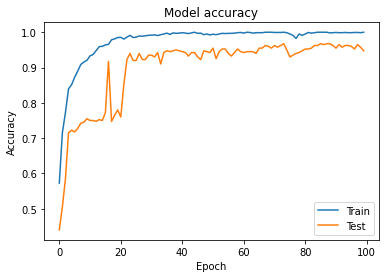

In [100]:
# plot training

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [101]:
model.evaluate(X_test, y_test, verbose=2)

13/13 - 0s - loss: 0.1914 - acc: 0.9475


[0.19138690829277039, 0.9474999904632568]